In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.sparse import vstack
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import os

In [2]:
articles = pd.read_csv("shared_articles.csv", delimiter= ',')
interactions = pd.read_csv("users_interactions.csv", delimiter= ',')

len(articles)
#interactions.head(10)

3122

In [3]:
#1
#Pre-processing, labeling event ratings

#function that creates eventRatings
def rank_events(data, exists=True):
    if exists:
        data = pd.read_csv ('df.csv', delimiter= ',')
        return(data)
    else: 
        data['eventRating'] = ''

        for session in data['sessionId']:
            df1= data[data['sessionId']==session]
            for content in df1['contentId']:
                df = df1[df1['contentId']==content]
                if df.empty:
                    continue
                idx = df.index.values.tolist()
                if (df['eventType'].str.contains("LIKE")).any():
                    data.loc[idx, 'eventRating'] = 5.0
                elif ((df['eventType'].str.contains("FOLLOW")).any() & (df['eventType'].str.contains("BOOKMARK")).any()):
                    data.loc[idx, 'eventRating'] = 4.0
                elif ((df['eventType'].str.contains("FOLLOW")).any() | (df['eventType'].str.contains("BOOKMARK")).any() & ~((df['eventType'].str.contains("FOLLOW")).any() & (df['eventType'].str.contains("BOOKMARK")).any())):
                    data.loc[idx, 'eventRating'] = 3.0
                elif ((df['eventType'].str.contains("COMMENT CREATED")).any() & ~((df['eventType'].str.contains("BOOKMARK")).any() | (df['eventType'].str.contains("FOLLOW")).any() | (df['eventType'].str.contains("LIKE")).any())):
                    data.loc[idx, 'eventRating'] = 2.0
                elif ((df['eventType'].str.contains("VIEW")).any() & ~((df['eventType'].str.contains("COMMENT CREATED")).any() | (df['eventType'].str.contains("BOOKMARK")).any() | (df['eventType'].str.contains("FOLLOW")).any() | (df['eventType'].str.contains("LIKE")).any())):
                    data.loc[idx,'eventRating'] = 1.0
        data.to_csv('df.csv')            
        return(data)                       

#set to False if eventRatings has not been created yet
interactions = rank_events(interactions, os.path.isfile("df.csv"))
interactions["eventRating"].head(10)

0    1.0
1    1.0
2    5.0
3    5.0
4    1.0
5    5.0
6    1.0
7    1.0
8    5.0
9    1.0
Name: eventRating, dtype: float64

In [4]:
#1

#function that filters dataset according to wanted number of user and article interactions and computes popularity ranking of given set 
def filter_df(data, articles, user_interactions_at_least, article_interactions_at_least, pivot=True):

    #Selecting articles and users with enough interactions
    users_interactions_count = data.groupby(['personId', 'contentId']).size().groupby('personId').size()
    print('number of users:', len(users_interactions_count))
    users_with_enough_interactions_df = users_interactions_count[users_interactions_count >= user_interactions_at_least].reset_index()[['personId']]

    article_interactions_count = data.groupby(['personId', 'contentId']).size().groupby('contentId').size()
    articles_with_enough_interactions_df = article_interactions_count[article_interactions_count >= article_interactions_at_least].reset_index()[['contentId']]

    print("articles with at least", article_interactions_at_least, "interactions:", len(articles_with_enough_interactions_df))
    print("users with at least", user_interactions_at_least, "interactions:", len(users_with_enough_interactions_df))
    print('number of interactions:', len(data))
    interactions_from_selected_users_df = data.merge(users_with_enough_interactions_df, 
                how = 'right',
                left_on = 'personId',
                right_on = 'personId')
    print('number of interactions from users with at least 3 interactions:', len(interactions_from_selected_users_df))


    interactions_from_selected_users_df = interactions_from_selected_users_df.merge(articles_with_enough_interactions_df, 
                how = 'right',
                left_on = 'contentId',
                right_on = 'contentId')
    print("number of interactions users with at least 3 interactions and with articles of at least 2 interactions", len(interactions_from_selected_users_df))

    #article_interactions_count = data.groupby(['personId', 'contentId']).size().groupby('contentId').size()
    #articles_with_enough_interactions_df = article_interactions_count[article_interactions_count >= article_interactions_at_least].reset_index()[['contentId']]
    articles_fil = articles[articles['contentId'].isin(articles_with_enough_interactions_df['contentId'])]
    print("num articles:", len(articles_fil))

    #select unique item/user interactions
    if  pivot==False:
        #interactions_filtered = interactions_from_selected_users_df.groupby(['personId', 'contentId'])['eventRating'].sum().reset_index() 
        interactions_filtered = interactions_from_selected_users_df[['personId', 'contentId','eventRating']].drop_duplicates()
        #item_popularity = interactions_selected.groupby('contentId')['eventRating'].sum().sort_values(ascending=False).reset_index()
    else:
        interactions_df =interactions_from_selected_users_df[['personId', 'contentId','eventRating']]
        interactions_filtered = interactions_from_selected_users_df[['personId', 'contentId','eventRating']]
        interactions_filtered = interactions_filtered.pivot_table(index='personId', columns='contentId', values='eventRating', fill_value=0)
    
    item_popularity = []

    print('number of of unique user/item interactions:', len(interactions_filtered))

    return(interactions_filtered, interactions_df, articles_fil)

interactions_selected, interactions_df, articles = filter_df(data=interactions, articles=articles, user_interactions_at_least=3, article_interactions_at_least=2, pivot=True)  
interactions_selected.head(30)  

number of users: 1895
articles with at least 2 interactions: 2744
users with at least 3 interactions: 1400
number of interactions: 72312
number of interactions from users with at least 3 interactions: 71244
number of interactions users with at least 3 interactions and with articles of at least 2 interactions 70849
num articles: 2760
number of of unique user/item interactions: 1400


contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9171475473795142532,-9166778629773133902,-9161596996229760398,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0,0.0,0,0,0
-9212075797126931087,0.0,0.0,0.0,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0,0.0,0,0,0
-9207251133131336884,0.0,5.0,0.0,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0,0.0,0,0,0
-9199575329909162940,0.0,0.0,0.0,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0,0.0,0,0,0
-9196668942822132778,0.0,0.0,0.0,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0,0.0,0,0,0
-9188188261933657343,0.0,0.0,0.0,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0,0.0,0,0,0
-9172914609055320039,0.0,0.0,0.0,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0,0.0,0,0,0
-9156344805277471150,0.0,0.0,0.0,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0,0.0,0,0,0
-9120685872592674274,0.0,0.0,0.0,0,0,0,0,0,0,0.0,...,0,0.0,0,0,0,0,0.0,0,0,0


In [5]:
user_ids = list(interactions_selected.index)
content_ids = list(interactions_selected.T.index)
#mask = np.random.rand(len(interactions_selected)) < 0.8
#train_set = interactions_selected[mask] 
#test_set = interactions_selected[~mask] 

#test_set.head(10)
print(user_ids==interactions_selected.index.unique().values)
len(interactions_selected.index.unique().values)

print(885269153482673496 in content_ids)
#print(len(user_ids), ((interactions_df[interactions_df["personId"]].drop_duplicates)))


[ True  True  True ...  True  True  True]
False


In [6]:
#indexing by personId
pre_processed_data_index = interactions_df.set_index('personId')
#pre_processed_data_index = interactions_selected

#train-test split
train_set, test_set = train_test_split(interactions_df,  stratify=interactions_df['personId'], train_size=0.80)
train_set_index = train_set.set_index('personId')
test_set_index = test_set.set_index('personId')

#train_set_index = train_set
#test_set_index = test_set


print('Train set size:', len(train_set))
print('Test set size:', len(test_set))
af=[0 for i in range(0, len(list(test_set_index.index.unique().values))) if not (list(test_set_index.index.unique().values))[i] in user_ids]
print(af)
print((885269153482673496 in train_set.index.unique().values))
885269153482673496 in interactions_df['personId']


matrix_sparse = np.array(train_set_index.pivot_table(index='personId', columns='contentId', values='eventRating', fill_value=0))
user_matrix_sparse = csr_matrix(train_set_index.pivot_table(index='personId', columns='contentId', values='eventRating', fill_value=0))
matrix_sparse_test = np.array(test_set_index.pivot_table(index='personId', columns='contentId', values='eventRating', fill_value=0))
user_matrix_sparse_test = csr_matrix(test_set_index.pivot_table(index='personId', columns='contentId', values='eventRating', fill_value=0))

def similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

user_similarity = similarity(matrix_sparse, kind='user')
item_similarity = similarity(matrix_sparse, kind='item')

def predict(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

item_prediction = predict(matrix_sparse, item_similarity, kind='item')
user_prediction = predict(matrix_sparse, user_similarity, kind='user')

from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

item_prediction = predict(matrix_sparse, item_similarity, kind='item')
user_prediction = predict(matrix_sparse, user_similarity, kind='user')

print('User-based CF MSE: ' + str(get_mse(user_prediction, matrix_sparse_test)))
print('Item-based CF MSE: ' + str(get_mse(item_prediction, matrix_sparse_test)))



Train set size: 56679
Test set size: 14170
[]
False
User-based CF MSE: 6.416517831167438
Item-based CF MSE: 6.415249478537303


In [7]:
print(pd.DataFrame(user_similarity))
#cf_preds_df = pd.DataFrame(user_similarity, columns = content_ids, index=user_ids).transpose()

              0             1             2             3             4     \
0     1.000000e+00  2.438299e-11  1.165156e-11  2.251887e-02  4.962917e-11   
1     2.438299e-11  1.000000e+00  8.238898e-02  3.184649e-11  7.018624e-11   
2     1.165156e-11  8.238898e-02  1.000000e+00  1.521804e-11  3.353892e-11   
3     2.251887e-02  3.184649e-11  1.521804e-11  1.000000e+00  6.482037e-11   
4     4.962917e-11  7.018624e-11  3.353892e-11  6.482037e-11  1.000000e+00   
...            ...           ...           ...           ...           ...   
1395  2.865341e-11  4.052204e-11  1.936371e-11  3.742406e-11  2.474358e-01   
1396  2.372147e-02  3.354723e-11  1.603075e-11  3.098248e-11  6.828206e-11   
1397  1.424218e-02  2.014149e-11  2.887420e-01  1.860163e-11  4.099600e-11   
1398  3.790490e-02  5.360563e-11  2.561578e-11  4.950738e-11  1.091089e-10   
1399  1.528655e-02  1.080923e-11  5.165255e-12  9.982841e-12  2.200111e-02   

              5             6             7             8      

In [8]:
#from sklearn.neighbors import NearestNeighbors
#knn = NearestNeighbors(metric='cosine', algorithm='brute')
#knn.fit(train_set)
#distances, indices = knn.kneighbors(test_set, n_neighbors=101)

#indices[0][0]
#test_set.iloc[[0,2,3]]

#idx = test_set.index.get_loc(-8802075878443651241)
#nearest_rows = indices[idx]
#print(idx)
#print(np.max(nearest_rows))
#print(interactions_selected[-9216926795620865886])

#interactions_selected.corrwith(interactions_selected[-9216926795620865886]).sort_values(ascending=False).head(10)
#user_id = -8802075878443651241
#user_list = interactions[interactions['personId'] == user_id]
#highest_rated_item = user_list[user_list['eventRating'] == max(user_list['eventRating'])]['contentId'].iloc[0]
#print(movie_id)


#print(list(range(len(interactions_selected["personId"]))))
#item_matrix_sparse = csr_matrix(interactions_selected.T)
#user_matrix_sparse = csr_matrix(interactions_selected)

#users = dict(zip(user_ids, list(range(len(interactions_df["personId"])))))
#contents = dict(zip(content_ids, list(range(len(interactions_df["contentId"])))))
#users_inv = dict(zip(list(range(len(interactions_df["personId"]))), user_ids))
#contents_inv = dict(zip(list(range(len(interactions_df["contentId"]))), content_ids))

#def find_similar(id, matrix, dictionary, dictionary_inv, k):
#     
#    neighbour_ids = []
#     
 #   idx = dictionary[id]
  #  vec = matrix[idx]
#    k+=1
#    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric='cosine')
#    kNN.fit(matrix)
#    vec = vec.reshape(1,-1)
#    neighbour = kNN.kneighbors(vec, return_distance=False)
#    for i in range(0,k):
#        n = neighbour.item(i)
#        neighbour_ids.append(dictionary_inv[n])
#    neighbour_ids.pop(0)
#    return neighbour_ids

#similar_ids = find_similar(content_id, item_matrix_sparse, contents, contents_inv, 10)
#print(similar_ids)

tm= train_set_index.pivot_table(index='personId', columns='contentId', values='eventRating', fill_value=0)
print(tm.head(10))

kNN = NearestNeighbors(n_neighbors=3, algorithm="brute", metric='cosine')
kNN.fit(tm)
#print(kNN.predict(tm))

def find_similar(self, id, matrix, dictionary, dictionary_inv, k):
     
        neighbour_ids = []
        idx = dictionary.get(id)
        #print("item name:", id, "item dict index:", idx)
        vec = matrix[idx]
        k+=1
        kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric='cosine')
        kNN.fit(matrix)
        vec = vec.reshape(1,-1)
        neighbour = kNN.kneighbors(vec, return_distance=False)
        for i in range(0,k):
            n = neighbour.item(i)
            neighbour_ids.append(dictionary_inv.get(n))
        neighbour_ids.pop(0)
        return neighbour_ids


contentId             -9222795471790223670  -9216926795620865886  \
personId                                                           
-9223121837663643404                     0                     0   
-9212075797126931087                     0                     0   
-9207251133131336884                     0                     5   
-9199575329909162940                     0                     0   
-9196668942822132778                     0                     0   
-9188188261933657343                     0                     0   
-9172914609055320039                     0                     0   
-9156344805277471150                     0                     0   
-9120685872592674274                     0                     0   
-9109785559521267180                     0                     0   

contentId             -9194572880052200111  -9192549002213406534  \
personId                                                           
-9223121837663643404                     0     

In [86]:
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

class CFrecommender2:
    MODEL_NAME = 'Collaborative Filtering'

    def __init__(self, items=None, item_based=True):
        
        #user all data
        #self.matrix = csr_matrix(interactions_selected)

        #use train data
        self.matrix = csr_matrix(train_set_index.pivot_table(index='personId', columns='contentId', values='eventRating', fill_value=0)) 
        #self.matrix_test = csr_matrix(test_set_index.pivot_table(index='personId', columns='contentId', values='eventRating', fill_value=0))

        self.users = dict(zip(user_ids, list(range(len(user_ids)))))
        self.contents = dict(zip(content_ids, list(range(len(content_ids)))))
        self.users_inv = dict(zip(list(range(len(user_ids))), user_ids))
        self.contents_inv = dict(zip(list(range(len(content_ids))), content_ids))

        self.item_based = item_based
        self.items = items


    def get_model_name(self):
        return self.MODEL_NAME
    

    def users_highest_item(self, user_id):
        user_list = interactions_df[interactions_df['personId'] == user_id]
        #print(user_list)
        highest_rated_item = user_list[user_list['eventRating'] == max(user_list['eventRating'])]['contentId'].iloc[0]
        #print(highest_rated_item) 
        return(highest_rated_item)

    def find_similar(self, matrix, item_based=True):
        if item_based:
            # For item-based collaborative filtering, transpose the matrix
            matrix = matrix.T

        # Calculate cosine similarity
        similarity_matrix = cosine_similarity(matrix, dense_output=False)
        return similarity_matrix

    def recommend_items(self, user_id, items_to_ignore=[], topn=15, item_based=True, verbose=False):
        
        similarity_matrix = self.find_similar(self.matrix, item_based)

        if item_based:
            
        # Get the index of the user in the matrix
            user_index = self.users.get(user_id)

            similar_item_to = self.users_highest_item(user_id)

            # Compute the scores based on cosine similarity
            scores = similarity_matrix[self.contents.get(similar_item_to)]
            scores = pd.DataFrame(scores.todense())

            # Filter out items already interacted by the user
            #scores = np.array([score if idx not in items_to_ignore else -1 for idx, score in enumerate(scores)])
            scores = np.array([score if self.contents_inv.get(idx) not in items_to_ignore else -1 for idx, score in enumerate(scores)])

            recommended_item_indices = np.argsort(scores, kind='heapsort')[::-2][:topn]

        #    Get contentIds and scores for top items
            recommended_items = [self.contents_inv.get(idx) for idx in recommended_item_indices]
            scores = [scores[idx] for idx in recommended_item_indices]

        elif not item_based:
            user_index = self.users.get(user_id)
            scores = similarity_matrix[user_index]
            scores = pd.DataFrame(scores.todense())
            #recommended_items = [self.users_highest_item(user) for user in recommended_users]
            # Get indices of top items
            recommended_item_indices = np.argsort(scores, kind='heapsort')[::-2][:topn]

            # Get contentIds and scores for top items
            recommended_items = [self.users_highest_item(self.users_inv(idx)) for idx in recommended_item_indices]
            scores = [scores[idx] for idx in recommended_item_indices]

        recommendations_df = pd.DataFrame({
            'contentId': recommended_items,
            'eventRating': scores
        })

        if verbose:
            if self.items is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventRating', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df


user_recommender_model2 = CFrecommender2(items=articles, item_based=False)
item_recommender_model2 = CFrecommender2(items=articles, item_based=True)
item_recommender_model2.recommend_items(-9016528795238256703)

,contentId,eventRating
0,9209629151177723638,2737
1,9207286802575546269,2735
2,9175693555063886126,2733
3,9158289456544908688,2731
4,9136323715291453594,2729
5,9122627895188486603,2727
6,9112765177685685246,2725
7,9079880752026843473,2723
8,9056727675613132316,2721
9,9045808098977760576,2719


In [61]:

class CFrecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, items=None, item_based=True):
        self.item_matrix_sparse = csr_matrix(interactions_selected.T)
        self.user_matrix_sparse = csr_matrix(interactions_selected)

        self.users = dict(zip(user_ids, list(range(len(user_ids)))))
        self.contents = dict(zip(content_ids, list(range(len(content_ids)))))
        self.users_inv = dict(zip(list(range(len(user_ids))), user_ids))
        self.contents_inv = dict(zip(list(range(len(content_ids))), content_ids))

        self.item_based = item_based
        self.items = items

        
    def get_model_name(self):
        return self.MODEL_NAME
    
    def find_similar(self, id, matrix, dictionary, dictionary_inv, k):
     
        neighbour_ids = []
        idx = dictionary.get(id)
        #print("item name:", id, "item dict index:", idx)
        vec = matrix[idx]
        k+=1
        kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric='cosine')
        kNN.fit(matrix)
        vec = vec.reshape(1,-1)
        neighbour = kNN.kneighbors(vec, return_distance=False)
        for i in range(0,k):
            n = neighbour.item(i)
            neighbour_ids.append(dictionary_inv.get(n))
        neighbour_ids.pop(0)
        return neighbour_ids
    
    def users_highest_item(self, user_id):
        user_list = interactions_df[interactions_df['personId'] == user_id]
        highest_rated_item = user_list[user_list['eventRating'] == max(user_list['eventRating'])]['contentId'].iloc[0]
        #print(highest_rated_item) 
        return(highest_rated_item)
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=101, verbose=False):

        if self.item_based:
            #find users highest rated item, then find similar items to it using cosine similarity
            similar_item_to = self.users_highest_item(user_id)
            recommended_items = self.find_similar(id=similar_item_to, matrix=self.item_matrix_sparse, dictionary=self.contents, dictionary_inv=self.contents_inv, k=topn)
            recommendations = interactions_df[interactions_df['contentId'].isin(recommended_items)]

        else:
            #find similar users using cosine similarity, then find highest rated item for each highest rating user
            similar_user_to = self.find_similar(id=user_id, matrix=self.user_matrix_sparse, dictionary=self.users, dictionary_inv=self.users_inv, k=topn)
            recommended_items = [self.users_highest_item(user) for user in similar_user_to]
            recommendations = interactions_df[interactions_df['contentId'].isin(recommended_items)]

        #sort recommended items based on event rating
        #print(len(recommendations))
        #sorted_user_predictions = recommendations.sort_values(ascending=False).reset_index()

        # Recommend the highest predicted rating items that user has not interacted with
        #print(recommendations)
        recommendations_df = recommendations[~recommendations['contentId'].isin(items_to_ignore)].sort_values(by='eventRating', ascending = False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventRating', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

#users = dict(zip(user_ids, list(range(len(interactions_df["personId"])))))    
#print(users.get(list(test_set.T.index)[0]))    
user_recommender_model = CFrecommender(items=articles, item_based=False)
item_recommender_model = CFrecommender(items=articles, item_based=True)
item_recommender_model.recommend_items(-9016528795238256703)

,personId,contentId,eventRating
37159,-8853658195208337106,569574447134368517,5.0
23447,3891637997717104548,-3248233692182971167,5.0
10275,3636910968448833585,-6623581327558800021,5.0
22059,-1380636509010496168,-3678789633202302491,5.0
22058,-1380636509010496168,-3678789633202302491,5.0
...,...,...,...
19909,8164031568920151381,-4145260601063545880,5.0
19908,8164031568920151381,-4145260601063545880,5.0
19906,8164031568920151381,-4145260601063545880,5.0
19884,6196511437047227700,-4145260601063545880,5.0


In [96]:
class Recall_n:

    def get_items_interacted(self, person_id, interactions_dat):
        # Get the user's data and merge in the movie information.
        interacted_items = interactions_dat.loc[person_id]['contentId']
        return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

    def get_not_interacted_items_sample(self, person_id, sample_size, seed=12):
        interacted_items = self.get_items_interacted(person_id, pre_processed_data_index)
        all_items = set(articles['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(list(non_interacted_items), sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = test_set_index.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        #print(person_id)
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=self.get_items_interacted(person_id, train_set_index), topn=1000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=101, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(test_set_index.index.unique().values)):
            #print(len(list(test_set_index.index.unique().values)), len(user_ids))
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
recall_n_evaluator = Recall_n() 

In [18]:
class NDCG:

    def dcg_at_k(self, r, k, method=0):
        """Score is discounted cumulative gain (dcg)
        Relevance is positive real values.  Can use binary
        as the previous methods.
        Example from
        http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
        >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
        >>> dcg_at_k(r, 1)
        3.0
        >>> dcg_at_k(r, 1, method=1)
        3.0
        >>> dcg_at_k(r, 2)
        5.0
        >>> dcg_at_k(r, 2, method=1)
        4.2618595071429155
        >>> dcg_at_k(r, 10)
        9.6051177391888114
        >>> dcg_at_k(r, 11)
        9.6051177391888114
        Args:
            r: Relevance scores (list or numpy) in rank order
                (first element is the first item)
            k: Number of results to consider
            method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                    If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
        Returns:
            Discounted cumulative gain
        """
        r = np.asfarray(r)[:k]
        if r.size:
            if method == 0:
                return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
            elif method == 1:
                return np.sum(r / np.log2(np.arange(2, r.size + 2)))
            else:
                raise ValueError('method must be 0 or 1.')
        return 0.


    def ndcg_at_k(self, r, k, method=1):
        """Score is normalized discounted cumulative gain (ndcg)
        Relevance is positive real values.  Can use binary
        as the previous methods.
        Example from
        http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
        >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
        >>> ndcg_at_k(r, 1)
        1.0
        >>> r = [2, 1, 2, 0]
        >>> ndcg_at_k(r, 4)
        0.9203032077642922
        >>> ndcg_at_k(r, 4, method=1)
        0.96519546960144276
        >>> ndcg_at_k([0], 1)
        0.0
        >>> ndcg_at_k([1], 2)
        1.0
        Args:
            r: Relevance scores (list or numpy) in rank order
                (first element is the first item)
            k: Number of results to consider
            method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                    If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
        Returns:
            Normalized discounted cumulative gain
        """
        dcg_max = self.dcg_at_k(sorted(r, reverse=True), k, method)
        if not dcg_max:
            return 0.
        return self.dcg_at_k(r, k, method) / dcg_max
    
    def get_items_interacted(self, person_id, interactions_dat):
        # Get the user's data and merge in the movie information.
        interacted_items = interactions_dat.loc[person_id]['contentId']
        return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

    def evaluate_model_for_user(self, model, person_id, k):
        #Getting the items in test set
        interacted_values_testset = test_set_index.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user

        personal_recommendations = model.recommend_items(person_id, items_to_ignore=self.get_items_interacted(person_id, train_set_index), topn=101)
        ndcg = self.ndcg_at_k(personal_recommendations['eventRating'], k)

        random.seed(12)
        personal_recommendations_rand = random.sample(list(interactions_df['eventRating']), 1000)
        ndcg_rand = self.ndcg_at_k(personal_recommendations_rand, k)

        person_metrics = {'ndcg':ndcg,
                          'ndcg_rand': ndcg_rand,
                          'comp_rand': (ndcg-ndcg_rand),
                          'interacted_count': interacted_items_count_testset}
        return person_metrics

    def evaluate_model(self, model, k):
            #print('Running evaluation for users')
            people_metrics = []
            for idx, person_id in enumerate(list(test_set_index.index.unique().values)):
                person_metrics = self.evaluate_model_for_user(model, person_id, k)  
                person_metrics['_person_id'] = person_id
                people_metrics.append(person_metrics)
            print('%d users processed' % idx)

            detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
            ndcg = detailed_results_df['ndcg'].sum() / len(detailed_results_df)
            ndcg_comp = detailed_results_df['comp_rand'].sum() / len(detailed_results_df)
            global_metrics = {'modelName': model.get_model_name(),
                            'ndcg': ndcg,
                            'ndcg_comp': ndcg_comp}    
            return global_metrics, detailed_results_df    

recall_ndcg_evaluator = NDCG() 


r = [2, 1, 2, 0]
recall_ndcg_evaluator.ndcg_at_k(r, 4, method=1)

0.9651954696014428

In [97]:
#Evaluating Item-based model

print('Item-based recommendation model: Recall_N:')
pop_global_metrics_item_recall, pop_detailed_results_df_item_recall = recall_n_evaluator.evaluate_model(item_recommender_model2)
print('\nGlobal metrics:\n%s' % pop_global_metrics_item_recall)
pop_detailed_results_df_item_recall.head(10)

print('Item-based recommendation model: NDCG:')
pop_global_metrics_item_ndcg, pop_detailed_results_df_item_ndcg = recall_ndcg_evaluator.evaluate_model(item_recommender_model2, k=101)
print('\nGlobal metrics:\n%s' % pop_global_metrics_item_ndcg)
pop_detailed_results_df_item_ndcg.head(10)

Item-based recommendation model: Recall_N:
1355 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.018822353627050887, 'recall@10': 0.0390605480136587}
Item-based recommendation model: NDCG:
1355 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'ndcg': 1.0, 'ndcg_comp': 0.5626073203052397}


,ndcg,ndcg_rand,comp_rand,interacted_count,_person_id
0,1.0,0.437393,0.562607,265,-1032019229384696495
3,1.0,0.437393,0.562607,240,3609194402293569455
40,1.0,0.437393,0.562607,228,-1443636648652872475
1,1.0,0.437393,0.562607,194,-2626634673110551643
21,1.0,0.437393,0.562607,137,-3596626804281480007
90,1.0,0.437393,0.562607,122,-2979881261169775358
133,1.0,0.437393,0.562607,119,2416280733544962613
51,1.0,0.437393,0.562607,115,3636910968448833585
26,1.0,0.437393,0.562607,109,3302556033962996625
185,1.0,0.437393,0.562607,105,-709287718034731589


In [98]:
print('User-based recommendation model: Recall_N:')
pop_global_metrics_user_recall, pop_detailed_results_df_user_recall = recall_n_evaluator.evaluate_model(user_recommender_model2)
print('\nGlobal metrics:\n%s' % pop_global_metrics_user_recall)
pop_detailed_results_df_user_recall.head(10)

print('User-based recommendation model: NDCG:')
pop_global_metrics_user_ndcg, pop_detailed_results_df_user_ndcg = recall_ndcg_evaluator.evaluate_model(user_recommender_model2, k=101)
print('\nGlobal metrics:\n%s' % pop_global_metrics_user_ndcg)
pop_detailed_results_df_user_ndcg.head(10)

User-based recommendation model: Recall_N:
1355 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.018822353627050887, 'recall@10': 0.0390605480136587}
User-based recommendation model: NDCG:
1355 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'ndcg': 1.0, 'ndcg_comp': 0.5626073203052397}


,ndcg,ndcg_rand,comp_rand,interacted_count,_person_id
0,1.0,0.437393,0.562607,265,-1032019229384696495
3,1.0,0.437393,0.562607,240,3609194402293569455
40,1.0,0.437393,0.562607,228,-1443636648652872475
1,1.0,0.437393,0.562607,194,-2626634673110551643
21,1.0,0.437393,0.562607,137,-3596626804281480007
90,1.0,0.437393,0.562607,122,-2979881261169775358
133,1.0,0.437393,0.562607,119,2416280733544962613
51,1.0,0.437393,0.562607,115,3636910968448833585
26,1.0,0.437393,0.562607,109,3302556033962996625
185,1.0,0.437393,0.562607,105,-709287718034731589


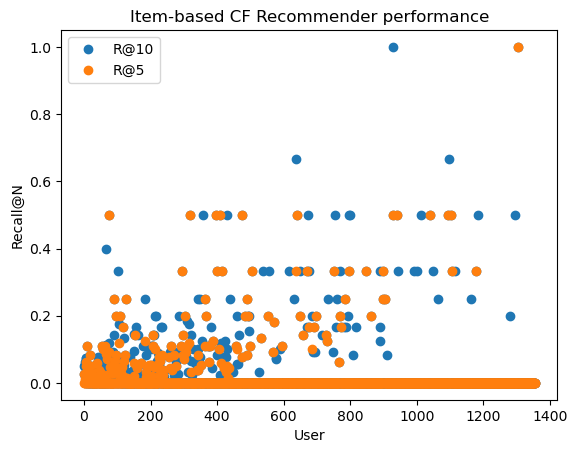

In [99]:
import matplotlib.pyplot as plt

plt.plot(pop_detailed_results_df_item_recall["recall@10"], "o")
plt.plot(pop_detailed_results_df_item_recall["recall@5"], "o")
plt.xlabel("User")
plt.legend(["R@10", "R@5"], loc="upper left")
plt.ylabel("Recall@N")
plt.title("Item-based CF Recommender performance")
plt.show()

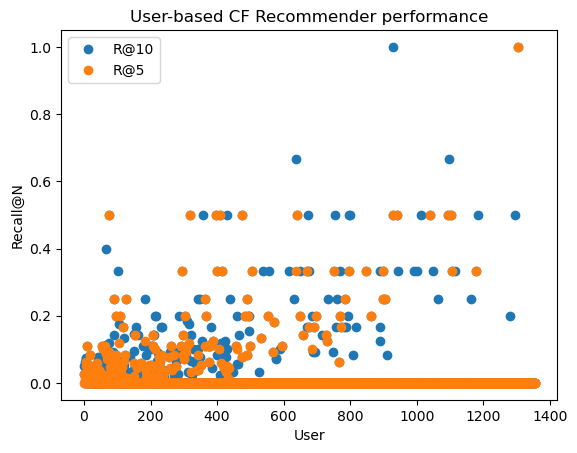

In [100]:
plt.plot(pop_detailed_results_df_user_recall["recall@10"], "o")
plt.plot(pop_detailed_results_df_user_recall["recall@5"], "o")
plt.xlabel("User")
plt.legend(["R@10", "R@5"], loc="upper left")
plt.ylabel("Recall@N")
plt.title("User-based CF Recommender performance")
plt.show()